# Train and Predict Drones

### Abstract

...


### Introduction

...


### Dataset



# 🧠 1. Setup

pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

### 1.0 Installing depedencies

In [ ]:
!pip install ultralytics markdown rich wrapt pandas mlflow huggingface_hub opencv-python -q

### 1.1 Importing Libraries

In [41]:
from utils.files import list_files, sort_files_by_number
from IPython.display import display, Image as IPyImage
from ultralytics import YOLO, settings
from collections import defaultdict
from huggingface_hub import login
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from datetime import datetime
from mlflow import log_param

import pandas as pd
import ultralytics
import numpy as np
import hashlib
import random
import mlflow
import shutil
import math
import re
import os

ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.13.9 torch-2.7.0+cu126 CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
Setup complete ✅ (8 CPUs, 23.3 GB RAM, 428.6/464.2 GB disk)


### 1.2 Global Definitions

In [5]:
DATASET_NAME_DIR = './datasets/new_dataset/'  # must end with /
TRAINING_DATASET_DIRECTORY = DATASET_NAME_DIR + 'training/'
VALIDATION_DATASET_DIRECTORY = DATASET_NAME_DIR + 'valid/'
MODELS_DIRECTORY = './models/'
RUNS_DIRECTORY = "./runs"

### 1.3 Global Settings

In [19]:
# YOLO settings
settings.update({"mlflow": True})

# MLflow settings
mlflow.set_tracking_uri("https://hibou.pythonanywhere.com/")
mlflow.set_experiment(experiment_id="869246232133219410")

# Hugging Face login
login("")

### 1.4 Global Structure

In [10]:
dataset_structure = {
    "path": "",
    "name": "",
    "train_files_images": [],
    "valid_files_images": [],
    "train_files_labels": [],
    "valid_files_labels": []
}

### 1.5 Global Function Definitions

In [46]:
def update_dataset_structure():
    dataset_structure["path"] = DATASET_NAME_DIR
    dataset_structure["train_files_images"] = sort_files_by_number(
        list_files(TRAINING_DATASET_DIRECTORY, [".jpg", ".jpeg", ".JPG", ".JPEG"], True))
    dataset_structure["valid_files_images"] = sort_files_by_number(
        list_files(VALIDATION_DATASET_DIRECTORY, [".jpg", ".jpeg", ".JPG", ".JPEG"], True))
    dataset_structure["train_files_labels"] = sort_files_by_number(
        list_files(TRAINING_DATASET_DIRECTORY, [".txt"], True))
    dataset_structure["valid_files_labels"] = sort_files_by_number(
        list_files(VALIDATION_DATASET_DIRECTORY, [".txt"], True))
    dataset_structure["name"] = DATASET_NAME_DIR.split("/")[-2]


def delete_files_in_dataset(files_to_delete: list):
    try:
        confirm = input("Files are going to be deleted. Type 'yes' to continue: ").strip().lower()
        if confirm != 'yes':
            print("Deletion aborted by user.")
            return

        for file in files_to_delete:
            if os.path.isfile(file):
                os.remove(file)
                print(f"Deleted: {file}")
            else:
                print(f"Warning: File does not exist: {file}")

    except KeyboardInterrupt:
        print("\nDeletion aborted by user (KeyboardInterrupt).")
    finally:
        try:
            update_dataset_structure()
        except NameError:
            pass


def backup_dataset():
    dataset_path = dataset_structure.get("path", "")
    backup_dir = os.path.join(dataset_path, "backup")
    os.makedirs(backup_dir, exist_ok=True)

    now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    target_name = f"{dataset_structure["name"]}-{now}"
    target_path = os.path.join(backup_dir, target_name)

    # Copytree with ignore to exclude the backup folder itself
    def ignore_backup(src, names):
        return {"backup"} if "backup" in names else set()

    shutil.copytree(dataset_path, target_path, ignore=ignore_backup)
    print(f"Backup created at: {target_path}")
    return str(target_path)

Backup created at: ./datasets/new_dataset/backup/new_dataset-2025-11-27_18-23-01


'./datasets/new_dataset/backup/new_dataset-2025-11-27_18-23-01'

# 📂 2. Dataset

### 2.1 Acquire Dataset

Download dataset from hugging face.

### 2.2 Data Structure Check

##### Directory path validation

In [32]:
update_dataset_structure()

print(f"Number of images in training folder: {len(dataset_structure['train_files_images'])}")
print(f"Number of images in valid folder: {len(dataset_structure['valid_files_images'])}")
#
print(f"\nNumber of TXT files in train labels folder: {len(dataset_structure['train_files_labels'])}")
print(f"Number of TXT files in val labels folder: {len(dataset_structure['valid_files_labels'])}")

Number of images in training folder: 4436
Number of images in valid folder: 625

Number of TXT files in train labels folder: 4437
Number of TXT files in val labels folder: 625


##### Duplicate files

Check for duplicate images and labels.

In [22]:
duplicate_paths_to_check = [
    dataset_structure["train_files_images"],
    dataset_structure["valid_files_images"],
    dataset_structure["train_files_labels"],
    dataset_structure["valid_files_labels"],
]


def sha3_file(path, chunk_size=8192):
    hash_sha3 = hashlib.sha3_256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            hash_sha3.update(chunk)
    return hash_sha3.hexdigest()


duplicates_array = []

for path in duplicate_paths_to_check:

    # Build list of (hash, path)
    pairs = [
        (sha3_file(f), f)
        for f in path
    ]

    # Group paths by hash
    hash_map = defaultdict(list)
    for h, p in pairs:
        hash_map[h].append(p)

    # Extract only duplicates
    duplicates = {h: paths for h, paths in hash_map.items() if len(paths) > 1}
    duplicates_array.append(duplicates)

    # Print results
    if duplicates:
        print("Duplicate files found:")
        for h, paths in duplicates.items():
            print(f"Hash: {h}")
            for p in paths:
                print(f"  - {p}")
    else:
        print(f"No duplicate files found in the scanned directories.")


No duplicate files found in the scanned directories.
No duplicate files found in the scanned directories.
No duplicate files found in the scanned directories.
No duplicate files found in the scanned directories.


##### ⚠️Delete duplicate files ⚠️

Delete for duplicate images and labels.

In [ ]:
try:
    if input("Files are going to be deleted. Write yes to continue.") == 'yes':
        for duplicates in duplicates_array:
            for paths in duplicates.values():
                for path in paths:
                    os.remove(path)
except KeyboardInterrupt:
    print("Deletion aborted.")
finally:
    update_dataset_structure()

##### Check for orphelins txt file

In [33]:
orphans_duplicate_paths_to_check = [
    dataset_structure["train_files_labels"],
    dataset_structure["valid_files_labels"],
]

orphelins_label = []

for path_list in orphans_duplicate_paths_to_check:
    for p in path_list:

        root, _ = os.path.splitext(p)

        candidates = [
            root + ".jpg",
            root + ".JPG",
            root + ".jpeg",
            root + ".JPEG",
            root + ".png",
            root + ".PNG",
        ]

        if not any(os.path.isfile(c) for c in candidates):
            orphelins_label.append(p)
            print(f"TXT file {p} does not belong to any image.")
print("Done")


TXT file ./datasets/new_dataset/training/23456787654.txt does not belong to any image.
Done


##### ⚠️Delete orphelin labels files ⚠️

Delete labels that don't belong to any images.

In [34]:
delete_files_in_dataset(orphelins_label)

hello
Deleted: ./datasets/new_dataset/training/23456787654.txt


##### Rename files

Rename images and labels from 0 to n images.

In [57]:
TRAIN = TRAINING_DATASET_DIRECTORY
VAL = VALIDATION_DATASET_DIRECTORY

jpeg_exts = [".jpg", ".jpeg", ".JPG", ".JPEG"]

tmp = os.path.join(DATASET_NAME_DIR, "tmp")


def numeric_key(name):
    nums = re.findall(r'\d+', name)
    return int(nums[0]) if nums else float('inf')


def collect_images(folder):
    return sorted(
        [f for f in os.listdir(folder) if f.endswith(tuple(jpeg_exts))],
        key=numeric_key
    )


def process(folder, start_i, out_dir):
    files = collect_images(folder)
    print(f"Processing {out_dir}...")

    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    for f in files:
        pass
        root, ext = os.path.splitext(f)

        # find real existing image
        image_path = None
        for e in jpeg_exts:
            p = os.path.join(folder, root + e)
            if os.path.isfile(p):
                image_path = p
                break

        if image_path is None:
            print("Missing image for:", f)
            continue

        label_path = os.path.join(folder, root + ".txt")
        if not os.path.isfile(label_path):
            os.rename(image_path, os.path.join(out_dir, f"{start_i}.jpg"))
            start_i += 1
            continue

        new_image = os.path.join(out_dir, f"{start_i}.jpg")
        new_label = os.path.join(out_dir, f"{start_i}.txt")

        # Move safely
        os.rename(image_path, new_image)
        os.rename(label_path, new_label)

        start_i += 1

    os.rmdir(folder)
    os.rename(out_dir, folder)

    return start_i


# === RUN ===
backup_dataset()

i = 0
i = process(TRAIN, i, tmp + '_training')
i = process(VAL, i, tmp + '_valid')

update_dataset_structure()

print(f"DONE — All files renamed safely into {DATASET_NAME_DIR}tmp_NAME")

Backup created at: ./datasets/new_dataset/backup/new_dataset-2025-11-27_18-44-42
Processing ./datasets/new_dataset/tmp_training...
Processing ./datasets/new_dataset/tmp_valid...
DONE — All files renamed safely into ./datasets/new_dataset/tmp_NAME


### Set labels

In [ ]:
!pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 -q
!pip install sam3 scikit-learn requests ipywidgets -q

In [24]:
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import plot_results
from sam3 import build_sam3_image_model

/home/adrien/miniconda3/envs/AI/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
2025/11/27 16:05:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e69543b6aa754f18811adc8a55074474', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/27 16:05:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [Errno 13] Permission denied: '/home/hibou'


🏃 View run receptive-turtle-718 at: https://hibou.pythonanywhere.com/#/experiments/869246232133219410/runs/e69543b6aa754f18811adc8a55074474
🧪 View experiment at: https://hibou.pythonanywhere.com/#/experiments/869246232133219410


In [ ]:
bpe_name = "bpe_simple_vocab_16e6.txt.gz"

##### Load model

In [ ]:
model = build_sam3_image_model(bpe_path=os.path.join(MODELS_DIRECTORY, bpe_name))
processor = Sam3Processor(model)

In [ ]:
image_path = f"datasets/new_dataset/training/633.jpg"
prompt = "drone"
confidence_threshold = 0.5

image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=confidence_threshold)
inference_state = processor.set_image(image)

processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt=prompt)
img0 = Image.open(image_path)
plot_results(img0, inference_state)

##### Settings

In [58]:
labelize_overwrite_label: bool = True
labelize_prompt: str = 'drone'
labelize_confidence_threshold: float = 0.62
labelize_drone_class = 0
labelize_output_label_file_directory = os.path.join(DATASET_NAME_DIR, 'new_labels')
labelize_output_label_file_errors = os.path.join(labelize_output_label_file_directory, 'errors.txt')
labelize_output_label_file_success = os.path.join(labelize_output_label_file_directory, 'success.txt')

liberalizations_path = [
    dataset_structure["train_files_images"],
    dataset_structure["valid_files_images"],
]


In [ ]:
os.makedirs(labelize_output_label_file_directory, exist_ok=True)

image_failed_labelize = []

for paths in liberalizations_path:
    for image_path in paths:
        root, ext = os.path.splitext(image_path)
        root_label_name = root.split("/")[-1]
        current_label_path = root + ".txt"
        saved_label_path = os.path.join(labelize_output_label_file_directory, root_label_name) + ".txt"

        if os.path.isfile(current_label_path) and not labelize_overwrite_label:
            continue

        if os.path.isfile(saved_label_path) and not labelize_overwrite_label:
            continue

        # Load image
        image = Image.open(image_path)
        if image.mode != "RGB":
            with open(labelize_output_label_file_errors, "a") as f:
                image_failed_labelize.append(image_path)
                f.write(f"{image_path} is not RGB.\n")
            continue
        width, height = image.size

        # Run SAM3 processor
        processor = Sam3Processor(model, confidence_threshold=labelize_confidence_threshold)
        inference_state = processor.set_image(image)
        processor.reset_all_prompts(inference_state)
        inference_state = processor.set_text_prompt(state=inference_state, prompt=labelize_prompt)

        # --- Save YOLO labels ---
        bboxes = inference_state.get("boxes", None)  # fixed

        if bboxes is None or len(bboxes) == 0:
            # print(f"No detections for {image_path}")
            image_failed_labelize.append(image_path)
            with open(labelize_output_label_file_errors, "a") as f:
                f.write(f"No detections for {image_path}\n")
            continue

        yolo_lines = []
        for box in bboxes:
            x_min, y_min, x_max, y_max = box  # SAM3 gives XYXY

            # Convert to YOLO format
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min

            cx = (x_min + bbox_width / 2) / width
            cy = (y_min + bbox_height / 2) / height

            nw = bbox_width / width
            nh = bbox_height / height

            yolo_lines.append(
                f"{labelize_drone_class} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}"
            )

        with open(saved_label_path, "w") as f:
            f.write("\n".join(yolo_lines))
        with open(labelize_output_label_file_success, "a") as f:
            f.write(f"Saved YOLO labels: {saved_label_path}\n")

    with open(labelize_output_label_file_success, 'r') as fp:
        nb_lines = len(fp.readlines())
        print(f"Successfully procedded files: {nb_lines} out of {len(paths)}")

In [ ]:
try:
    if input("Files are going to be deleted. Write yes to continue.") == 'yes':
        for image_path in image_failed_labelize:
            os.remove(image_path)
except KeyboardInterrupt:
    print("Deletion aborted.")

### 2.3 Check

Load N random images and show rectangles around the drones detected by SAM3.

In [43]:
def load_image_with_boxes(image_path, label_path):
    """Returns a PIL image with YOLO bounding boxes drawn."""
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    w, h = img.size

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            cls, xc, yc, bw, bh = map(float, line.split())

            # YOLO normalized → pixel coordinates
            x_center = xc * w
            y_center = yc * h
            box_width = bw * w
            box_height = bh * h

            x1 = x_center - box_width / 2
            y1 = y_center - box_height / 2
            x2 = x_center + box_width / 2
            y2 = y_center + box_height / 2

            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1), f"{int(cls)}", fill="red")

    return img

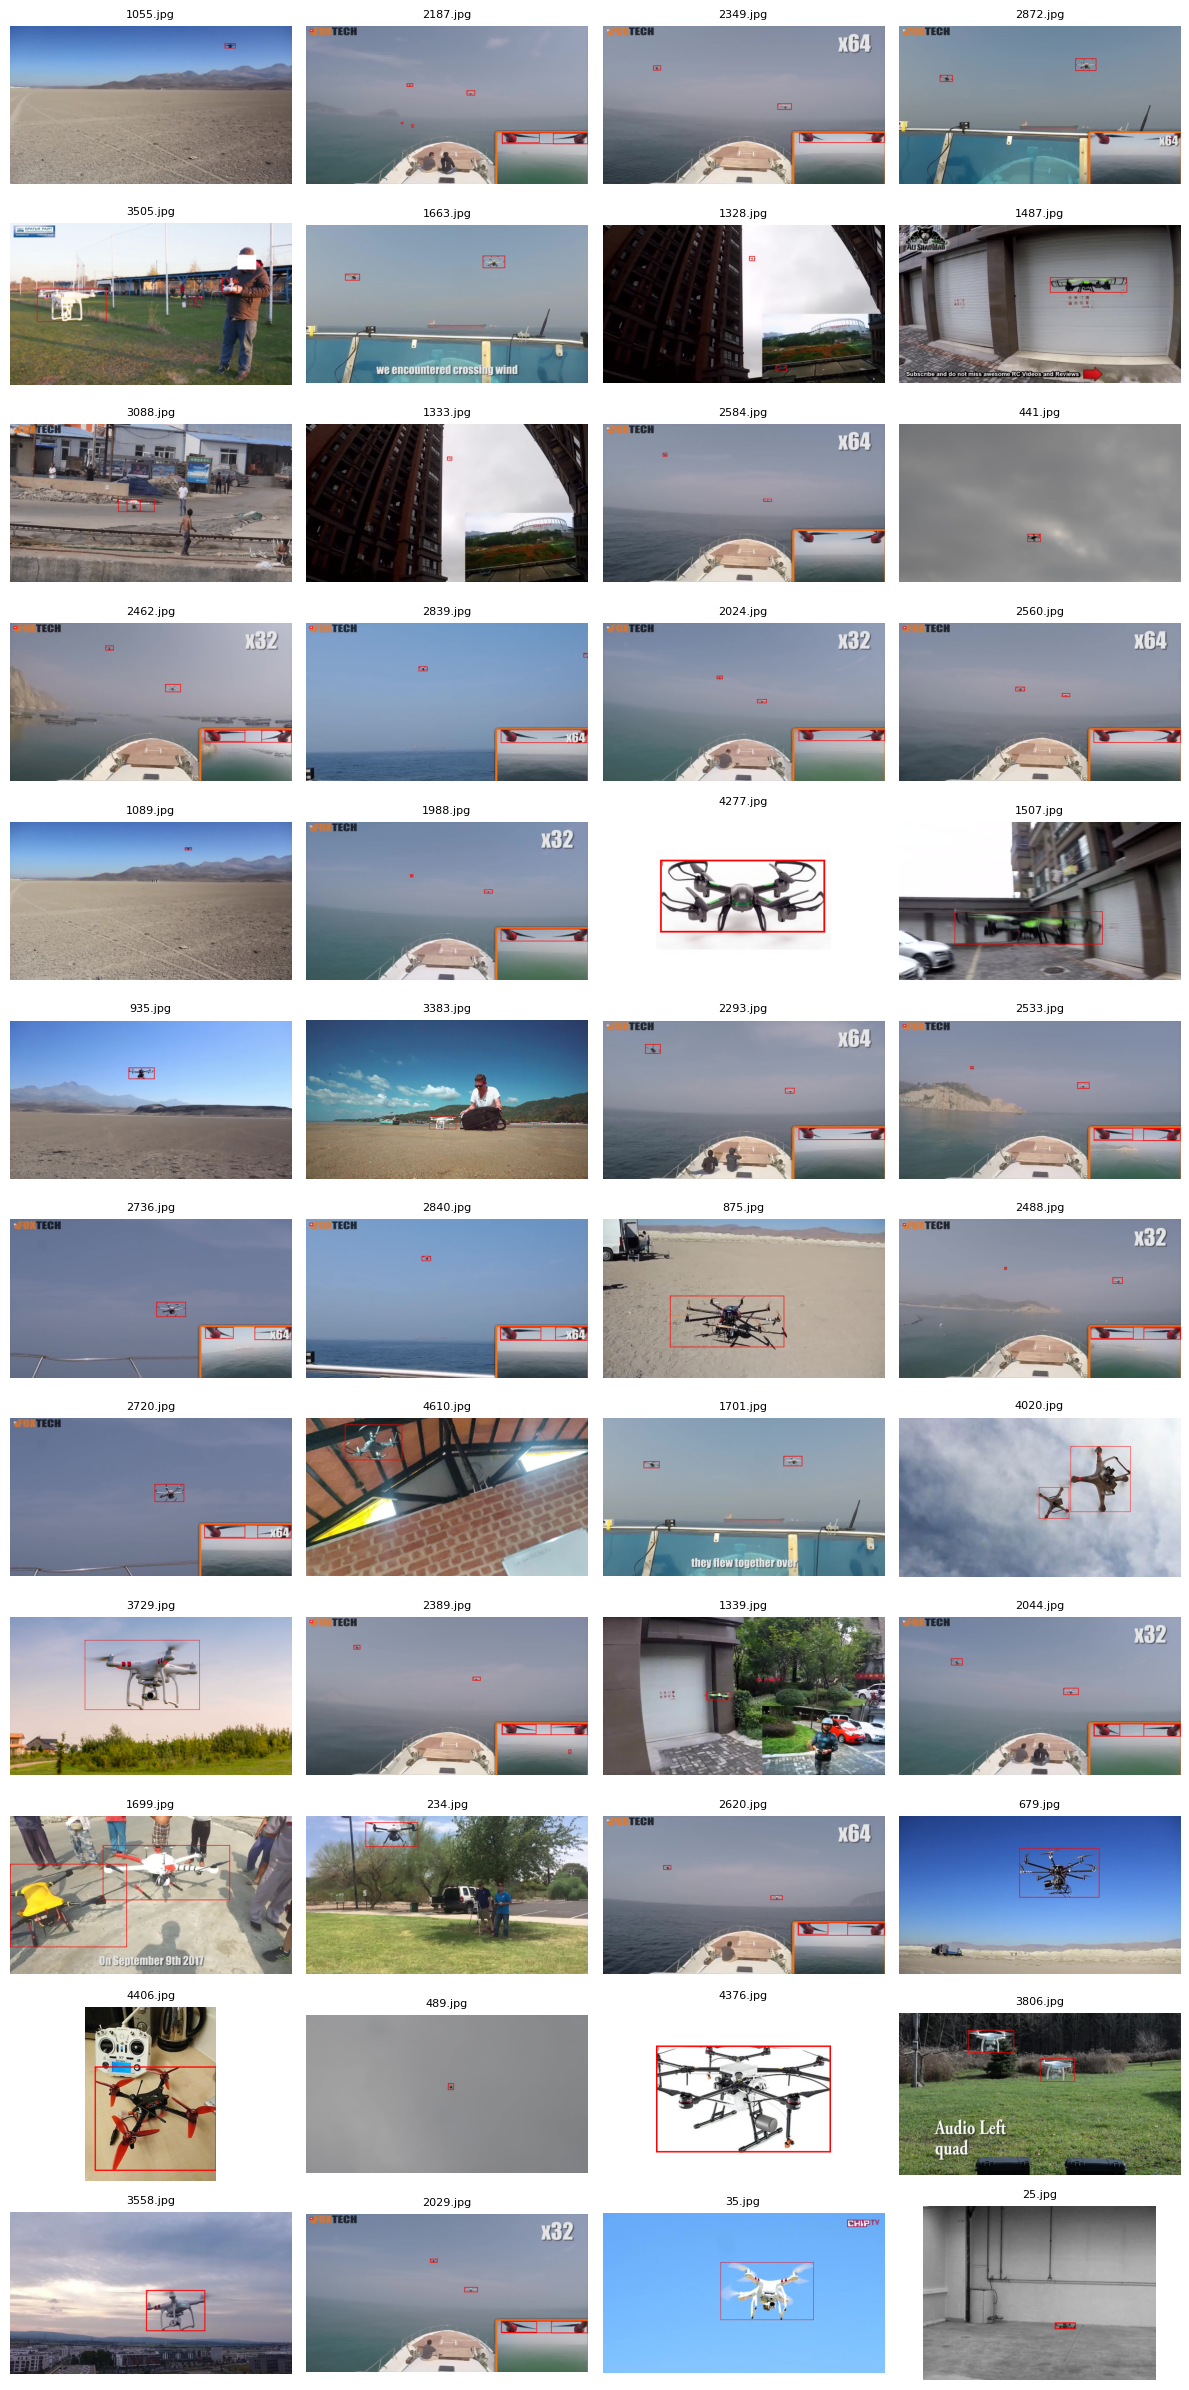

In [45]:
N = 48  # number of random samples
cols = 4

%matplotlib inline

# list all images
image_paths = [p for p in os.listdir(TRAINING_DATASET_DIRECTORY) if p.lower().endswith((".jpg", ".png"))]
sampled_images = random.sample(image_paths, min(N, len(image_paths)))

# -------- DISPLAY GRID -------- #

rows = math.ceil(len(sampled_images) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2))
axes = axes.flatten()

for ax, img_name in zip(axes, sampled_images):
    img_path = os.path.join(TRAINING_DATASET_DIRECTORY, img_name)
    label_path = os.path.join(TRAINING_DATASET_DIRECTORY, img_name.rsplit(".", 1)[0] + ".txt")

    img = load_image_with_boxes(img_path, label_path)

    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_name, fontsize=8)

# turn off unused axes
for ax in axes[len(sampled_images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# ⚙️ 3. Training

Purpose: Handle model setup and training configuration.

### 3.1 Model Selection

In [46]:
YOLO_MODELS = {
    "nano": "yolo11n.pt",
    "small": "yolo11s.pt",
    "medium": "yolo11m.pt",
    "large": "yolo11l.pt",
    "xlarge": "yolo11x.pt",
}

selected_size = "nano"
model = YOLO(MODELS_DIRECTORY + YOLO_MODELS[selected_size])

### 3.2 Training Configuration
Define hyperparameters (epochs, batch size, image size)

In [47]:
import yaml

data_yaml = dict(
    train=os.path.join('../../', TRAINING_DATASET_DIRECTORY),
    val=os.path.join('../../', VALIDATION_DATASET_DIRECTORY),
    nc=1,
    names=['drone']
)

data_config_path = os.path.join(DATASET_NAME_DIR, 'data.yaml')

with open(data_config_path, 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

%cat "$data_config_path"

{names: [drone], nc: 1, train: ../.././datasets/new_dataset/training/, val: ../.././datasets/new_dataset/valid/}


In [49]:
train_config = {
    'data': data_config_path,
    'epochs': 50,
    'imgsz': 640,
    'batch': 16,
    'lr0': 0.001,
    'optimizer': 'SGD',
    'project': RUNS_DIRECTORY,
    'name': "computer_vision"
}

train_config

{'data': './datasets/new_dataset/data.yaml',
 'epochs': 50,
 'imgsz': 640,
 'batch': 16,
 'lr0': 0.001,
 'optimizer': 'SGD',
 'project': './runs',
 'name': 'computer_vision'}

**Parameter breakdown:**

- **train**: Executes the YOLOv11x training pipeline.
- **model**=yolov11x.pt: Uses pre-trained YOLOv11x weights as initialization.
- **data**=/content/data.yaml: Specifies the dataset configuration file.
- **imgsz**=640: Sets input resolution to enhance small-object detection.
- **lr0**=0.001: Sets the learing rate for each training step.
- **epochs**=32: Defines the number of training cycles over the dataset.
- **batch**=16: Sets the batch size for each training step.
- **device**=0: Allocates GPU device 0 for training.
- **optimizer**=AdamW: As default, AdamW optimization algorithm utilized.

### 3.3 Run Training

In [50]:
# results = model.train(**train_config)
# plot_results(os.path.join(RUNS_DIRECTORY, "/train/results.csv"))

with mlflow.start_run() as run:
    # Log model + training configuration
    log_param("model_size", selected_size)

    # Log each training config parameter individually (better for MLflow UI)
    for k, v in train_config.items():
        log_param(k, v)

    # Train YOLOv11
    results = model.train(**train_config)

    # Log YOLO training metrics (loss, mAP, P, R, etc.)
    for key, value in results.results_dict.items():
        mlflow.log_metric(key, float(value))

    # Log training artifacts (weights, plots, results.csv)
    # Path YOLO uses for this run:
    run_path = os.path.join(train_config["project"], train_config["name"])

    # Log all important artifacts
    artifacts_to_log = [
        "weights/best.pt",
        "weights/last.pt",
        "results.csv",
        "results.png",
        "confusion_matrix.png",
        "F1_curve.png",
        "PR_curve.png",
        "P_curve.png",
        "R_curve.png"
    ]

    for fname in artifacts_to_log:
        full_path = os.path.join(run_path, fname)
        if os.path.exists(full_path):
            mlflow.log_artifact(full_path)

    # Log full run directory (optional but useful)
    mlflow.log_artifact(run_path)

    print("Logged to external MLflow run:", run.info.run_id)


New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.221 🚀 Python-3.13.9 torch-2.7.0+cu126 CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/new_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./models/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=comput

2025/11/27 16:12:25 INFO mlflow.tracking.fluent: Experiment with name './runs' does not exist. Creating a new experiment.
2025/11/27 16:12:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/11/27 16:12:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 16:12:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(fe9b63ebdd5d4a5d9fdb9503554d7bf3) to https://hibou.pythonanywhere.com/
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /home/adrien/Projects/Python/AI/notebooks/computer_vision/runs/computer_vision
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50         0G      1.098      2.648      1.158          8        640: 100% ━━━━━━━━━━━━ 278/278 0.2it/s 21:15<2.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 0.5it/s 36.9s2.1ss
                   all        625        669      0.812      0.613      0.789      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50         0G     0.9697      1.471      1.126         73        640: 59% ━━━━━━━───── 164/278 0.4it/s 12:48<4:405
🏃 View run bemused-owl-410 at: https:

KeyboardInterrupt: 

### 3.4 Result of training

In [ ]:
display(IPyImage(filename=os.path.join(RUNS_DIRECTORY, "/train/results.png")))

In [ ]:
results_paths = []

for root, _, files in os.walk(os.path.join(RUNS_DIRECTORY, "train")):
    for f in files:
        if f.lower().endswith((".jpg")):
            results_paths.append(os.path.join(root, f))
results_paths = sorted(results_paths)

In [ ]:
%matplotlib inline

for path in results_paths:
    image = np.array(Image.open(path))
    plt.figure(figsize=(20, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


### 3.5 Evaluate Model


In [ ]:
metrics = model.val()
metrics

### 3.6 Compare with previous trains

In [ ]:
saved_train_path = "./saved_trains"

# List all folders in the saved_train_path
folders_results = [dir for dir in os.listdir(saved_train_path) if os.path.isdir(os.path.join(saved_train_path, dir))]

# Convert folder names to datetime objects for sorting
folders_results_sorted = sorted(
    folders_results,
    key=lambda x: datetime.strptime(x, "%d-%m-%Y_%H:%M:%S"),
    reverse=True  # latest first
)

# Take the last 2 trainings by date
last_two_folders = folders_results_sorted[:2]

# Dictionary to store the last row of each folder
results_data = {}

for folder in last_two_folders:
    path = os.path.join(saved_train_path, folder)
    results_csv = os.path.join(path, "results.csv")

    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        # Get the last row as a dictionary
        last_row = df.iloc[-1].to_dict()

        # Compute a custom YOLO train score
        score = (
                last_row['metrics/mAP50-95(B)'] * 0.7 +
                last_row['metrics/recall(B)'] * 0.2 -
                last_row['val/box_loss'] * 0.1
        )

        # Add the score to the dictionary
        last_row['train_score'] = score

        results_data[folder] = last_row

# Convert the dictionary to a pandas DataFrame
summary_df = pd.DataFrame.from_dict(results_data, orient='index')
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'folder'}, inplace=True)

# Sort by train_score if desired
best_train = summary_df.sort_values(by='train_score', ascending=False)

# 4. Evaluation / Inference

Purpose: Evaluate results qualitatively and quantitatively.


### 4.1 Run Predictions

In [ ]:
best_path = os.path.join(RUNS_DIRECTORY, "train/weights/best.pt")

In [ ]:
custom_model = YOLO(best_path)
!rm -rf ./runs/predict
preds = custom_model.predict(VALIDATION_DATASET_DIRECTORY, save=True, project=RUNS_DIRECTORY)

### 4.2 Result of Prediction

In [ ]:
results = custom_model.predict(VALIDATION_DATASET_DIRECTORY, conf=0.2)
print(len(results))

### 4.3 Visualize Predictions

In [ ]:
predictions_paths = []

for root, _, files in os.walk(os.path.join(RUNS_DIRECTORY, "predict")):
    for f in files:
        if f.lower().endswith((".jpg", ".png", ".jpeg")):
            predictions_paths.append(os.path.join(root, f))

In [ ]:
cols = 4
max_images_preview = -1
rows = math.ceil(len(predictions_paths) / cols)

plt.figure(figsize=(cols * 3, rows * 2))  # dynamic size
for i, path in enumerate(predictions_paths):
    if max_images_preview != -1 and max_images_preview < len(predictions_paths):
        break
    img = Image.open(path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 📊 5. Analysis & Improvements
Purpose: Interpret and iterate.

### 5.1 Metrics Review

In [ ]:
metrics.box.map, metrics.box.map50, metrics.box.map75

### 5.2 Error Analysis

In [ ]:
metrics.confusion_matrix.plot()

### 5.3 Compare with previous trains

# ✅ 6. Export & Deployment

### 6.1 Save results

In [ ]:
# source = os.path.join(RUNS_DIRECTORY, "train")
# saved_success_file_name = ".saved.success"
#
# check_for_file = os.path.isfile(os.path.join(source, saved_success_file_name))
#
# if check_for_file:
#     print("Training already saved. If you want to save it again, delete the .saved.success file.")
# else:
#     now = datetime.now().strftime('%d-%m-%Y_%H:%M:%S')
#     destination = "./saved_trains/" + now
#
#     shutil.copytree(source, destination, dirs_exist_ok=True)
#
#     train_config_path = os.path.join(destination, 'train_config.json')
#     with open(train_config_path, 'w') as outfile:
#         yaml.dump(json.dumps(train_config), outfile, default_flow_style=True)
#
#     saved_file = os.path.join(source, '.saved.success')
#
#     with open(saved_file, "a") as f:
#         f.write(now)
#     print("Training saved successfully.")

New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.221 🚀 Python-3.13.9 torch-2.7.0+cu126 CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_external_mlflow, nbs=64, nms=Fals

2025/11/27 15:13:57 INFO mlflow.tracking.fluent: Experiment with name 'runs/train' does not exist. Creating a new experiment.
2025/11/27 15:13:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/11/27 15:13:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 15:13:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(171fab3f08504799b8c95571fe872f60) to https://hibou.pythonanywhere.com/
MLflow: disable with 'yolo settings mlflow=False'
🏃 View run unleashed-slug-501 at: https://hibou.pythonanywhere.com/#/experiments/869246232133219410/runs/171fab3f08504799b8c95571fe872f60
🧪 View experiment at: https://hibou.pythonanywhere.com/#/experiments/869246232133219410


KeyboardInterrupt: 